## Basics of TS:

Collation of different basic concepts of the different traditional time-series models and some basic intuition behind them

## Objective:
This kernel was made to serve as repository of various time-series concepts for beginners and I hope it would be useful as a refresher to some of the experts too :)

## Table of contents:
* Competition and data overview
* Imports ( data and packages )
* Basic exploration/EDA
* Single time-series 
    * Stationarity
    * Seasonality , Trend and Remainder
    * AR , MA , ARMA , ARIMA
    * Selecting P and Q using AIC
    * ETS
    * Prophet 
    * UCM
* Hierarchical time-series
    * Bottom's up
    * AHP
    * PHA 
    * FP 
    
    
## Competition and data overview:

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-[1c company](http://1c.ru/eng/title.htm). 

**What does the IC company do?:**

1C: Enterprise 8 system of programs is intended for automation of everyday enterprise activities: various business tasks of economic and management activity, such as management accounting, business accounting, HR management, CRM, SRM, MRP, MRP, etc.

**Data**:
We are provided with daily sales data for each store-item combination, but our task is to predict sales at a monthly level.

## Imports:


In [1]:
!ls ../input/*

../input/item_categories.csv  ../input/sample_submission.csv
../input/items.csv	      ../input/shops.csv
../input/sales_train.csv      ../input/test.csv


In [2]:
# Basic packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random as rd # generating random numbers
import datetime # manipulating date formats
# from pandas import datetime
# Viz
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots



# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# settings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Import all of them 
sales_train=pd.read_csv("../input/sales_train.csv")

# settings
import warnings
warnings.filterwarnings("ignore")

item_categories=pd.read_csv("../input/item_categories.csv")
items=pd.read_csv("../input/items.csv")
sample_submission=pd.read_csv("../input/sample_submission.csv")
shops=pd.read_csv("../input/shops.csv")
test=pd.read_csv("../input/test.csv")

In [4]:
# check every data file
print('==========================items categories============================')
item_categories.info()
item_categories.columns
print('===============================items===================================')
items.info()
print(items.columns)
print('===============================test====================================')
test.info()
print(test.columns)
print('=================================sales=================================')
sales_train.info()
print(sales_train.columns)
print('=================================shops===============================')
shops.info()
print(shops.columns)

==========================items categories============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
item_category_name    84 non-null object
item_category_id      84 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB
===============================items===================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
item_name           22170 non-null object
item_id             22170 non-null int64
item_category_id    22170 non-null int64
dtypes: int64(2), object(1)
memory usage: 519.7+ KB
Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
===============================test====================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
ID         214200 non-null int64
shop_id    214200 non-null int64
item_id    214200 non-nu

In [5]:
# agregate sales to monthly sale, the count of each item for each shop
mon_sales_eashop = sales_train.groupby(["date_block_num","shop_id","item_id"])["item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})
print(mon_sales_eashop.head(10))

                                item_price  item_cnt_day
date_block_num shop_id item_id                          
0              0       32            221.0           6.0
                       33            347.0           3.0
                       35            247.0           1.0
                       43            221.0           1.0
                       51            128.5           2.0
                       61            195.0           1.0
                       75             76.0           1.0
                       88             76.0           1.0
                       95            193.0           1.0
                       96             70.0           1.0


    item_category_id  item_name  item_id
0                 40       5035     5035
1                 55       2365     2365
2                 37       1780     1780
3                 31       1125     1125
4                 58        790      790
5                 30        756      756
6                 72        666      666
7                 19        628      628
8                 61        598      598
9                 23        501      501
10                43        471      471
11                57        427      427
12                56        397      397
13                67        394      394
14                63        366      366
15                76        333      333
16                41        332      332
17                69        317      317
18                38        310      310
19                62        295      295


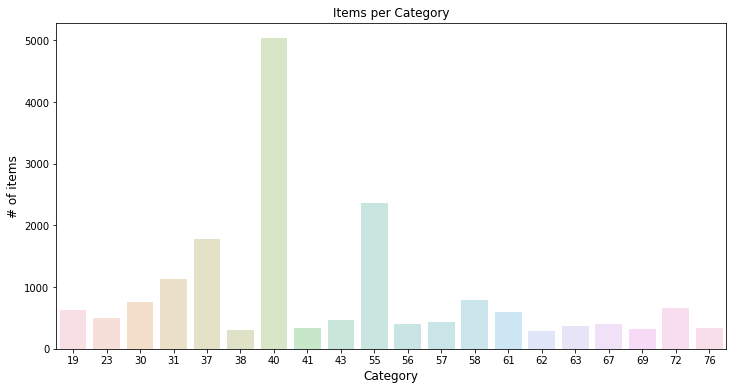

In [6]:
# to have a general understand to the data
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:20].reset_index()
print(x)
# #plot
plt.figure(figsize=(12,6))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.3)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

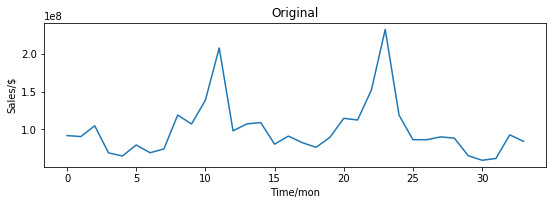

In [7]:
#the general trend of sales value 
monthList = sales_train.date_block_num.unique()
salesDict = {}

for item in monthList:
    salesDict[item] = 0

for item in sales_train.itertuples():
    salesDict[item.date_block_num] =  round(salesDict[item.date_block_num] + item.item_cnt_day * item.item_price, 2)

sale_values = pd.Series(list(salesDict.values()))

plt.figure(figsize=(9,9))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time/mon')
plt.ylabel('Sales/$')
plt.plot(sale_values)

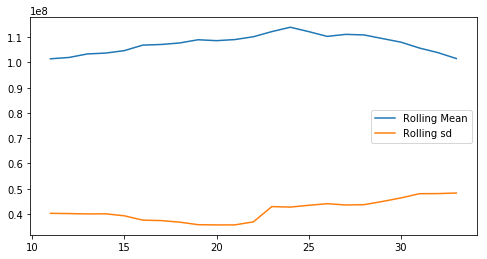

In [8]:
plt.figure(figsize=(8,4))
plt.plot(sale_values.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(sale_values.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

**Quick observations:**
There is an obvious "seasonality" (Eg: peak sales around a time of year) and a decreasing "Trend".

Let's check that with a quick decomposition into Trend, seasonality and residuals.


[  9.19470911e+07   9.06657074e+07   1.04932687e+08   6.91542855e+07
   6.50653125e+07   7.95504058e+07   6.93505999e+07   7.42979696e+07
   1.19081892e+08   1.07241613e+08   1.38665439e+08   2.07571731e+08
   9.82260230e+07   1.07431123e+08   1.09115405e+08   8.06517552e+07
   9.12817338e+07   8.26685387e+07   7.64879213e+07   8.96040923e+07
   1.14723594e+08   1.12525522e+08   1.52037599e+08   2.32025171e+08
   1.18927700e+08   8.65938839e+07   8.64762666e+07   9.02528138e+07
   8.85774382e+07   6.53979954e+07   5.94057872e+07   6.17489647e+07
   9.29051691e+07   8.43371131e+07]


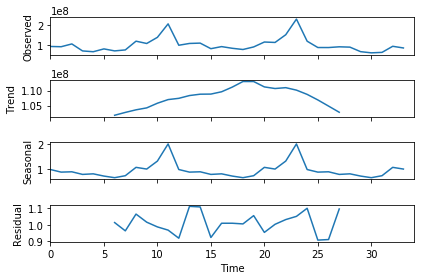

In [9]:
# divide a series to level, trend, seasonality, and noise components, 
# to check "additive" and "multiplicative" model
import statsmodels.api as sm
# multiplicative
print(sale_values.values)
res = sm.tsa.seasonal_decompose(sale_values.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

[  9.19470911e+07   9.06657074e+07   1.04932687e+08   6.91542855e+07
   6.50653125e+07   7.95504058e+07   6.93505999e+07   7.42979696e+07
   1.19081892e+08   1.07241613e+08   1.38665439e+08   2.07571731e+08
   9.82260230e+07   1.07431123e+08   1.09115405e+08   8.06517552e+07
   9.12817338e+07   8.26685387e+07   7.64879213e+07   8.96040923e+07
   1.14723594e+08   1.12525522e+08   1.52037599e+08   2.32025171e+08
   1.18927700e+08   8.65938839e+07   8.64762666e+07   9.02528138e+07
   8.85774382e+07   6.53979954e+07   5.94057872e+07   6.17489647e+07
   9.29051691e+07   8.43371131e+07]


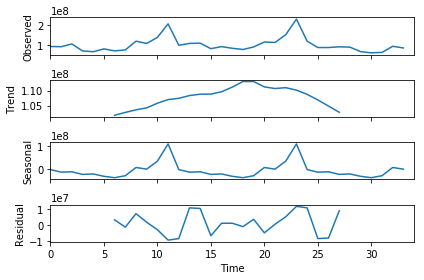

In [10]:
import statsmodels.api as sm
# multiplicative
print(sale_values.values)
res = sm.tsa.seasonal_decompose(sale_values.values, freq=12, model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [11]:
# Stationarity tests: ADF test to show whether the time serious is stable

def ADF_test(timeseries):
    stationary = True
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:1], index=['Test Statistic','p-value'])
    for key,value in dftest[4].items():
        if(key == "5%"): 
            dfoutput['Critical Value (%s)'%key] = value
    if dfoutput['Test Statistic'] < dfoutput['Critical Value (5%)']:
        stationary = True
    else: stationary = False 
    return stationary
    

t = ADF_test(sale_values)
t

True

In [12]:
# As test statistic < critical Value(5%), p value < 0.05, assume the series is stationary. 
# Test whether this is non-white noise sequence
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(sale_values, lags = [i for i in range(0,13)])

(array([ 44.39860132,   8.51852908,   9.84328929,  10.34710758,
         11.77668724,  15.01534001,  19.26259377,  26.8386871 ,
         31.79001473,  31.81933   ,  31.82942461,  33.0862474 ,  44.39860132]),
 array([             nan,   3.51548519e-03,   7.28713624e-03,
          1.58347443e-02,   1.90914828e-02,   1.02969931e-02,
          3.74238953e-03,   3.56308432e-04,   1.01561417e-04,
          2.13964919e-04,   4.27502101e-04,   5.09494680e-04,
          1.30588822e-05]))

In [13]:
# as pvalue is much less than stat and close to 0, this is not a white noise
# define a function to display ACF, PACF, PP plot and QQ plot:
def tsplot(y, lags=None, figsize=(10, 8), title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)   
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

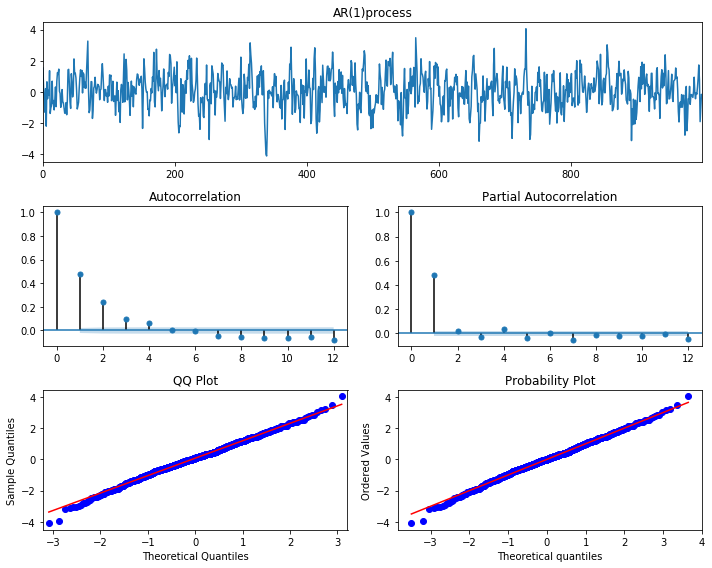

In [14]:
# Simulate an AR(1) process with alpha = 0.5
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = E = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + E[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

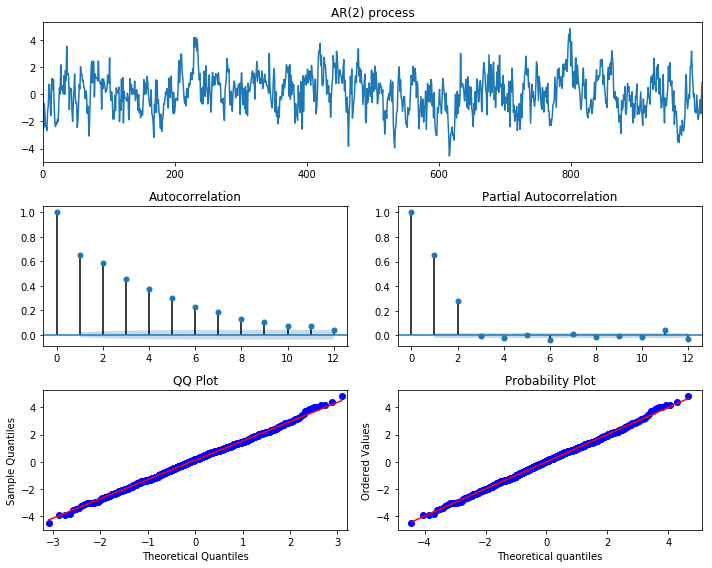

In [15]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([0.46, 0.3])
betas = np.array([0])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

#AR(1) process has ACF tailing out and PACF cutting off at lag=1 
#AR(2) process has ACF tailing out and PACF cutting off at lag=2

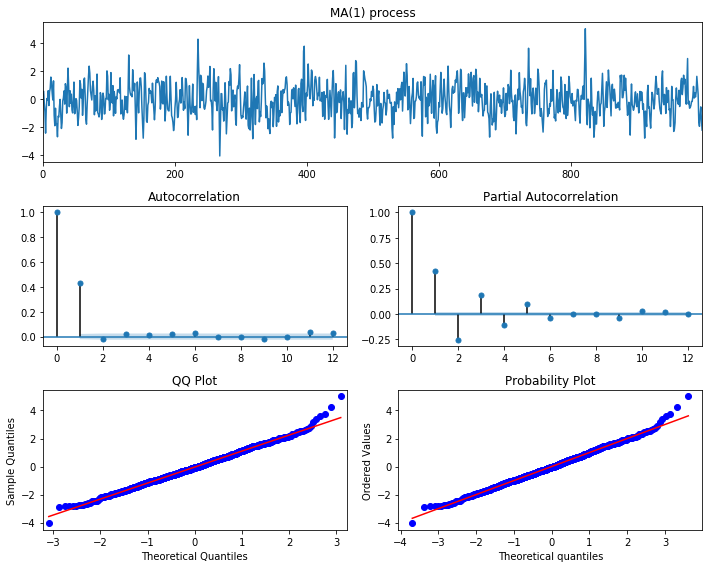

In [16]:
# Simulate an MA(1) process
# Set alpha for the AR equal to 0

n = int(1000)
alphas = np.array([0])
betas = np.array([0.65])


ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="MA(1) process")

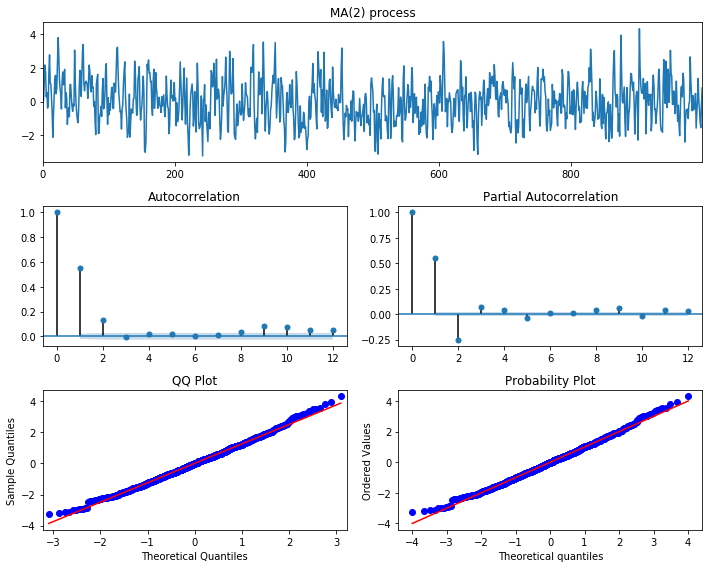

In [17]:
# Simulate an MA(2) process
# Set alpha for the AR equal to 0


n = int(1000)
alphas = np.array([0])
betas = np.array([0.7,0.2])


ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

MA2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(MA2, lags=12,title="MA(2) process")

## MA(1) process has ACF cut off at lag=1 and PACF tailing out 
## MA(2) process has ACF cut off at lag=2 and PACF tailing out 

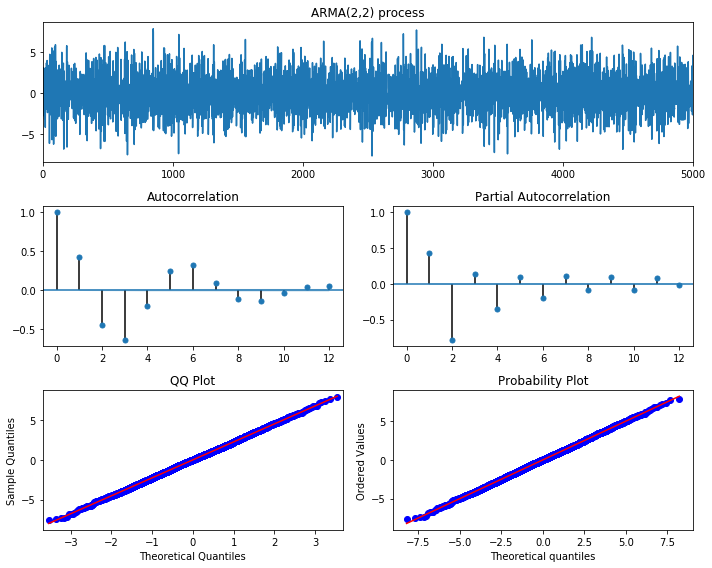

In [18]:
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

In [19]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


aic: 15326.68109 | order: (2, 2)


## We've correctly identified the order of the simulated process as ARMA(2,2). 

### Lets use it for the sales time-series.


In [20]:
# Simply use best_mdl.predict() to predict the next values

In [21]:
# adding the dates to the Time-series as index
ts=sale_values
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,0
0,2013-01-01,9.194709e+07
1,2013-02-01,9.066571e+07
2,2013-03-01,1.049327e+08
3,2013-04-01,6.915429e+07
4,2013-05-01,6.506531e+07


In [22]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [23]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,1.298021e+08,1.258834e+08,1.339590e+08
35,2015-12-01,2.127670e+08,2.087177e+08,2.170303e+08
36,2016-01-01,9.126164e+07,8.683623e+07,9.571792e+07
37,2016-02-01,5.176486e+07,4.729057e+07,5.588067e+07
38,2016-03-01,1.016833e+08,9.722829e+07,1.062990e+08


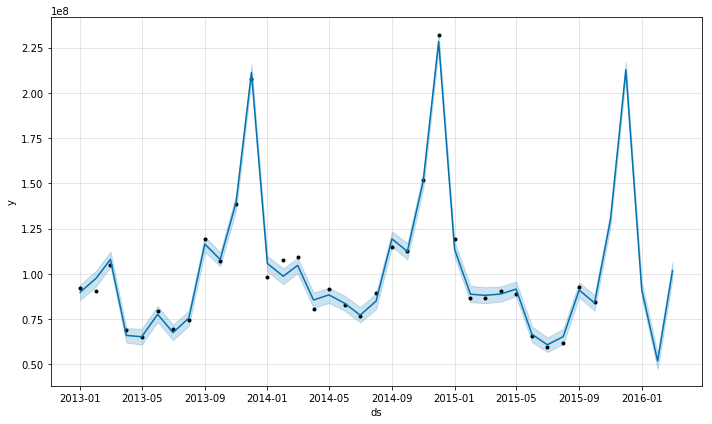

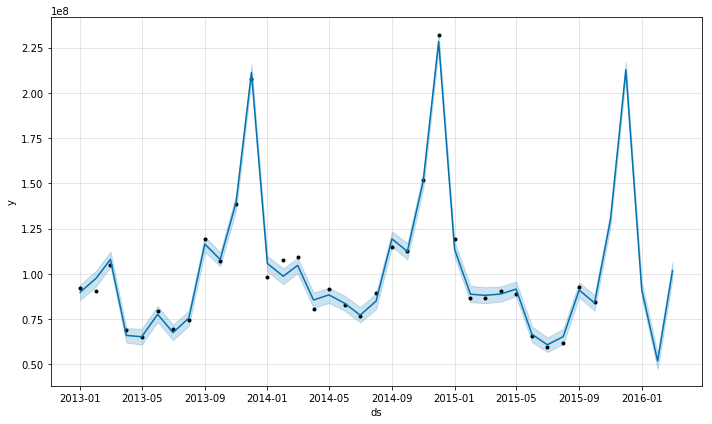

In [24]:
model.plot(forecast)

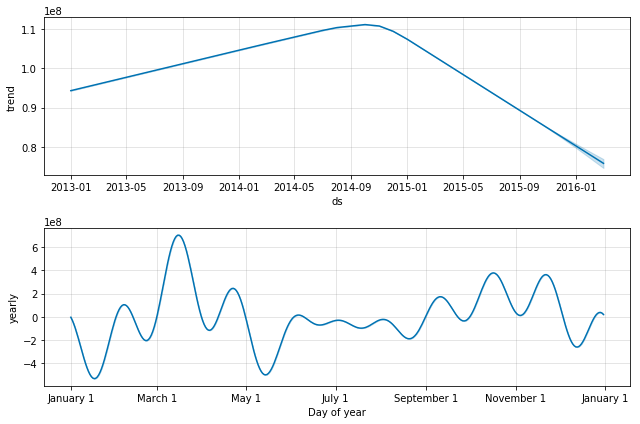

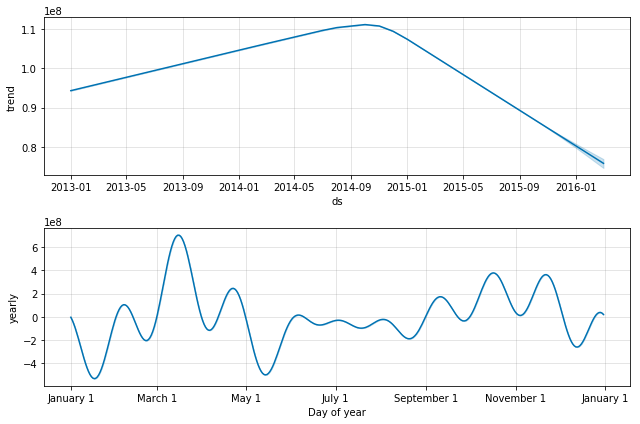

In [25]:
model.plot_components(forecast)

In [26]:
# To establish a new table including the date_block_num, item_id, item_cnt_day, item_category_id
# calculate the count of each categary sold in each mon
item_cat = sales_train[['date_block_num','item_id','item_cnt_day']]
print(type(items))
cat_mon = item_cat.join(items,on = 'item_id', how = "left", lsuffix='left')
cat_mon = cat_mon[['date_block_num','item_id', 'item_cnt_day', 'item_category_id']]
display(cat_mon.head(20))

<class 'pandas.core.frame.DataFrame'>


,date_block_num,item_id,item_cnt_day,item_category_id
0,0,22154,1.0,37
1,0,2552,1.0,58
2,0,2552,-1.0,58
3,0,2554,1.0,58
4,0,2555,1.0,56
5,0,2564,1.0,59
6,0,2565,1.0,56
7,0,2572,1.0,55
8,0,2572,1.0,55
9,0,2573,3.0,55


In [27]:
# the count of each categary sold in each month
mon_sales_eacat = cat_mon.groupby(["date_block_num","item_category_id"]).agg({"date_block_num": "mean","item_category_id": "mean", "item_cnt_day":"sum"})
display(mon_sales_eacat.head(10))
print(mon_sales_eacat.info())

date_block_num  item_category_id  \
date_block_num item_category_id                                     
0              0                              0                 0   
               1                              0                 1   
               2                              0                 2   
               3                              0                 3   
               4                              0                 4   
               5                              0                 5   
               6                              0                 6   
               9                              0                 9   
               11                             0                11   
               13                             0                13   

                                 item_cnt_day  
date_block_num item_category_id                
0              0                          1.0  
               1                          1.0  
               2                       1390.0  
               3                        440.0  
               4                        251.0  
               5                        623.0  
               6                        870.0  
               9                        149.0  
               11                       375.0  
               13                        84.0

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2077 entries, (0, 0) to (33, 83)
Data columns (total 3 columns):
date_block_num      2077 non-null int64
item_category_id    2077 non-null int64
item_cnt_day        2077 non-null float64
dtypes: float64(1), int64(2)
memory usage: 53.8 KB
None


In [28]:
#  set a list with date_block_num and item_cnt_day as the elements
listData = list()
cat_TS = list()

for i in range(84):
    listData.append(list())

for index, item in mon_sales_eacat.iterrows():
    listData[int(item['item_category_id'])].append([int(item['date_block_num']), int(item['item_cnt_day'])])

for i in range(84):
    date_series = list()
    sale_list = list()
    for j in range(len(listData[i])):
        date_series.append(listData[i][j][0])
    for k in range(34):
        if k not in date_series:
            listData[i].append([k,0])
            
    listData[i].sort()
    for l in range(34):
        sale_list.append(listData[i][l][1])
    cat_sale = pd.Series(sale_list)
    cat_TS.append(cat_sale)

    
# print(cat_TS)

    
# now I got a list with 84 sub list, which shows that for each item_category_id, how many sold(item_cnt_day) in each mon
# listData[i] sorted by mon,
# thus each listData[i] is the time series of sales of each product category


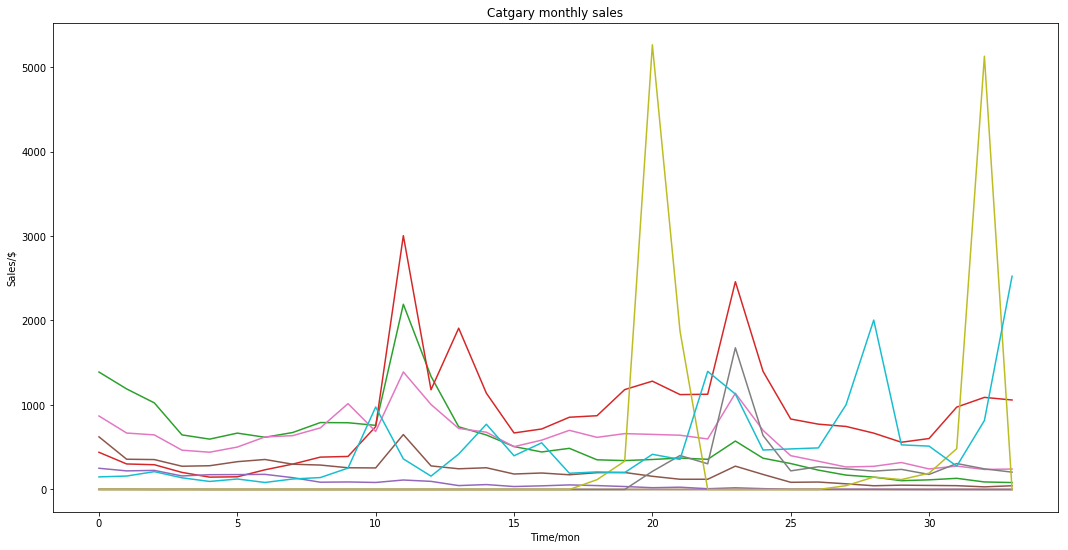

In [29]:
# the general monthly sales of categary 0 to 9
plt.figure(figsize=(18,9))
for i in range(10):
    plt.title('Catgary monthly sales')
    plt.xlabel('Time/mon')
    plt.ylabel('Sales/$')
    plt.plot(cat_TS[i])


In [30]:
# ADF test for time series of each categary
# if time series of any categary is not stationary, then take differencial process until it is staionary
# if time series of any categary is stationary, then take white noise test
falseCount = 0
for i in range(len(cat_TS)):
    result = ADF_test(cat_TS[i])
    d = 0
    loop = 0
    while result is False and loop < 5:
        diff = cat_TS[i].diff().dropna()
        result = ADF_test(diff)
        loop = loop + 1
    if result == False: falseCount = falseCount + 1
    print(result, 'loop = ', loop)
print('falseCount: ',falseCount)
#     print(i, result)

#     ADF_test(cat_TS[i])

# def ADF_test(timeseries, index):
#     stationary = True
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:1], index=['Test Statistic','p-value'])
#     for key,value in dftest[4].items():
#         if(key == "5%"): 
#             dfoutput['Critical Value (%s)'%key] = value
#     if dfoutput['Test Statistic'] < dfoutput['Critical Value (5%)']:
#         stationary = True
#     else: stationary = False 
#     return index, stationary
    

# t = ADF_test(sale_values, 'sale_values')

True loop =  0
True loop =  0
True loop =  1
True loop =  1
True loop =  0
True loop =  0
True loop =  1
True loop =  0
True loop =  0
False loop =  5
True loop =  0
True loop =  1
True loop =  0
True loop =  0
True loop =  0
True loop =  1
True loop =  0
True loop =  0
True loop =  0
True loop =  1
True loop =  1
True loop =  0
True loop =  0
True loop =  1
False loop =  5
True loop =  1
False loop =  5
True loop =  0
True loop =  0
True loop =  1
True loop =  1
False loop =  5
True loop =  1
True loop =  1
True loop =  0
True loop =  1
True loop =  0
False loop =  5
True loop =  0
True loop =  0
True loop =  1
True loop =  1
True loop =  0
True loop =  1
True loop =  1
False loop =  5
True loop =  0
False loop =  5
True loop =  0
True loop =  1
True loop =  0
True loop =  0
True loop =  0
False loop =  5
True loop =  1
True loop =  1
True loop =  0
False loop =  5
True loop =  0
True loop =  0
True loop =  1
True loop =  1
True loop =  1
True loop =  0
True loop =  0
True loop =  0
F